In [ ]:
!pip install imbalanced-learn

In [1]:
from sklearn.preprocessing import MinMaxScaler
from tsfresh import select_features
from tsfresh.feature_extraction import extract_features
import keras
from tensorflow.keras import layers
from tensorflow import keras

from tqdm import tqdm
import sys
sys.path.append('..')
from lib.download import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

usdt_tickers = get_pair_tickers()
data = pd.read_pickle(f'data/usdt_data_features/{usdt_tickers[1]}.pickle').astype(float)
data = data.dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
train_data = data_scaled[1:int(data.shape[0] * 0.8), :]
test_data = data_scaled[int(data.shape[0] * 0.8):-1, :]
#ajouter train test

ModuleNotFoundError: No module named 'scipy.sparse'

In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import numpy as np

def compute_silhouette_score(n_clusters, returns):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(returns)
    return silhouette_score(returns, kmeans.predict(returns))

silhouette_scores = []
returns = np.array(data['close'].pct_change().dropna()).reshape(-1,1)
cluster_sizes = [x*3 for x in range(1,10)]

#silh = [compute_silhouette_score(n_clusters, returns) for n_clusters in tqdm(cluster_sizes)]

In [ ]:
plt.plot(silh)

In [3]:
rets_df = data['close'].pct_change().dropna().reset_index(drop=True)
kmeans = KMeans(n_clusters=7, random_state=669)
kmeans.fit(returns)
classes = pd.DataFrame(kmeans.predict(returns))
classes.value_counts()

0    20275
3    10080
1     8661
6     2346
5     2008
2      291
4      227
dtype: int64

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    batch = keras.backend.shape(z_mean)[0]
    dim = keras.backend.int_shape(z_mean)[1]
    epsilon = keras.backend.random_normal(shape=(batch, dim))
    return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

def train_vae(latent_dim, train_data, test_data):
    encoder_inputs = keras.Input(shape=(train_data.shape[1],))
    x = layers.Dense(256, activation="relu")(encoder_inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation="relu")(latent_inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    decoder_outputs = layers.Dense(train_data.shape[1])(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    encoder_outputs = encoder(encoder_inputs)
    latent_outputs = encoder_outputs[0]
    latent_outputs = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    decoder_outputs = decoder(latent_outputs)

    vae = keras.Model(encoder_inputs, decoder_outputs, name="vae")

    vae.compile(optimizer="adam", loss="mse")
    history = vae.fit(train_data, train_data, epochs=100, batch_size=64, validation_data=(test_data, test_data), verbose=0)
    last_10_epochs_loss = history.history['val_loss'][-10:]
    mean_loss = np.mean(last_10_epochs_loss)
    return mean_loss, encoder, history

In [ ]:
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np

latent_dims = [x * 3 for x in range(5, 20)]
losss = []

def train_and_append_loss(latent_dim):
    mean_loss, encoder, history = train_vae(latent_dim, train_data, test_data)
    losss.append([mean_loss, latent_dim])

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(train_and_append_loss, latent_dim) for latent_dim in latent_dims]
    for f in tqdm(concurrent.futures.as_completed(futures), total=len(latent_dims)):
        pass
    
plt.scatter(np.array(losss).T[1], np.array(losss).T[0])

  0%|          | 0/15 [00:00<?, ?it/s]

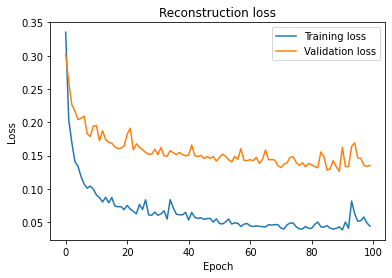

In [5]:
mean_loss, encore, history = train_vae(45, train_data, test_data)
import matplotlib.pyplot as plt
# Plot the reconstruction loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Reconstruction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
features_train = encore.predict(train_data)
features_test = encore.predict(test_data)
features = pd.concat([pd.DataFrame(features_train[0]), pd.DataFrame(features_test[0])],axis=0, ignore_index=True)
features.index = data.index
features.tail()

In [26]:
y_train = classes[1:len(train_data)+1]
y_test = classes[len(train_data)+1:]

In [27]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

lgbm = LGBMClassifier(class_weight='balanced')
lgbm.fit(train_data, y_train)

predictions = lgbm.predict(test_data)
predictions = pd.DataFrame(predictions)

accuracy_score on test dataset : 0.36812122593141167
              precision    recall  f1-score   support

           0       0.49      0.66      0.56      3345
           1       0.11      0.22      0.14       796
           2       0.05      0.04      0.04        46
           3       0.36      0.25      0.30      2781
           4       0.00      0.00      0.00         9
           5       0.22      0.08      0.12       861
           6       0.23      0.08      0.12       939

    accuracy                           0.37      8777
   macro avg       0.21      0.19      0.19      8777
weighted avg       0.36      0.37      0.35      8777



<AxesSubplot: >

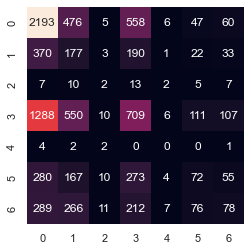

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
accuracy_test = accuracy_score(y_test, predictions)
print('accuracy_score on test dataset :', accuracy_test)
print(classification_report(predictions, y_test))
sns.set()
mat=confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)

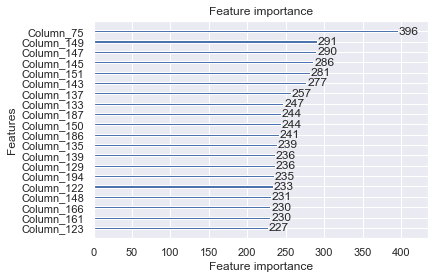

In [30]:
import lightgbm as lgb 
import matplotlib.pyplot as plt

# Plot the feature importances
lgb.plot_importance(lgbm.booster_, max_num_features=20)
plt.show()

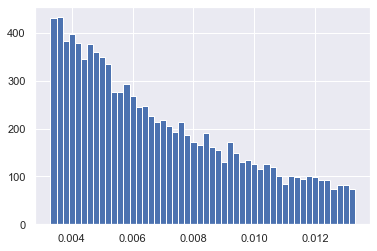

In [34]:
rets_df[classes[0]==3].hist(bins=50);

In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(train_data, y_train)

OH_ytrain = to_categorical(y_train_resampled)
OH_ytest = to_categorical(y_test)
X_train_resh = np.reshape(X_train_resampled, (X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_test_resh = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

timesteps, num_features = 1, 198

n_classes = len(np.unique(y_train_resampled))
class_weights = {i : 1/n_classes for i in range(n_classes)}

model = Sequential()
model.add(LSTM(7*24,input_shape=(timesteps, num_features), return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.8))
model.add(LSTM(7*24,kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(len(classes.value_counts()), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy'])

In [80]:
early_stop = EarlyStopping(patience=20)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=20)

In [81]:
history = model.fit(X_train_resh, OH_ytrain, epochs=50, class_weight=class_weights, batch_size=24*7*6, validation_data=(X_test_resh, OH_ytest))#, callbacks=[early_stop, reduce_lr])

Epoch 1/50
111/111 [==============================] - 6s 27ms/step - loss: 0.3612 - accuracy: 0.2454 - val_loss: 1.7402 - val_accuracy: 0.4034
Epoch 2/50
111/111 [==============================] - 2s 21ms/step - loss: 0.2587 - accuracy: 0.2826 - val_loss: 1.6195 - val_accuracy: 0.4194
Epoch 3/50
111/111 [==============================] - 2s 20ms/step - loss: 0.2555 - accuracy: 0.2949 - val_loss: 1.7105 - val_accuracy: 0.3574
Epoch 4/50
111/111 [==============================] - 2s 20ms/step - loss: 0.2532 - accuracy: 0.3071 - val_loss: 1.5586 - val_accuracy: 0.4421
Epoch 5/50
111/111 [==============================] - 2s 21ms/step - loss: 0.2515 - accuracy: 0.3145 - val_loss: 1.6165 - val_accuracy: 0.3867
Epoch 6/50
111/111 [==============================] - 2s 21ms/step - loss: 0.2500 - accuracy: 0.3234 - val_loss: 1.5964 - val_accuracy: 0.3998
Epoch 7/50
111/111 [==============================] - 2s 20ms/step - loss: 0.2490 - accuracy: 0.3268 - val_loss: 1.5884 - val_accuracy: 0.4093

KeyboardInterrupt: 

275/275 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      4545
           1       0.50      0.08      0.14      2396
           2       0.00      0.00      0.00         0
           3       0.14      0.06      0.08        70
           4       0.13      0.24      0.17      1021
           5       0.12      0.05      0.07       733
           6       0.03      0.08      0.04        12

    accuracy                           0.38      8777
   macro avg       0.22      0.16      0.16      8777
weighted avg       0.50      0.38      0.39      8777



<AxesSubplot: >

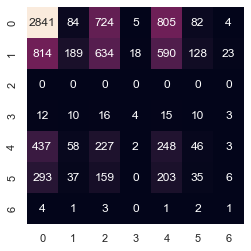

In [209]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

predictions = model.predict(X_test_resh)
predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, predictions)


print(classification_report(predictions, y_test))
sns.set()
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)

In [83]:
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

timesteps, num_features = X_train_resampled.shape[0], X_train_resampled.shape[1]

# Autoencoder Layers
input_layer = Input(shape=(timesteps, num_features))
encoded = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
encoded = MaxPooling1D(2, padding='same')(encoded)
encoded = Conv1D(64, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2, padding='same')(encoded)
encoded = Conv1D(128, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2, padding='same')(encoded)
encoded = Flatten()(encoded)

# LSTM and GRU Layers
lstm = LSTM(32, return_sequences=True)(encoded)
gru = GRU(32)(lstm)

# Dense Layers
dense = Dense(64, activation='relu')(gru)
dense = Dropout(0.5)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.5)(dense)
output_layer = Dense(n_classes, activation='softmax')(dense)

# Model Compilation
model = Model(input_layer, output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Model
model.fit(X_train_resampled, OH_ytrain, epochs=50, batch_size=32, callbacks=[EarlyStopping(patience=5), ReduceLROnPlateau(patience=3)])

ValueError: Input 0 of layer "lstm_35" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1774592)

In [44]:
classes.value_counts()

0    20103
4     9660
2     9239
1     2280
5     2109
6      258
3      239
dtype: int64

In [ ]:
recuperer la partie fiable de chaque DL et stacker

but => maximiser la precision sur les classes rares

fonction qui donne davantage de poids aux classes rares=> tester differents poids et calculer en fonction une rentabilité

predire chaque jour les classes pour chaque crypto, et faire un weight des crypto avec les meilleures predic tions

Boruta, avant de finaliser le predicteur

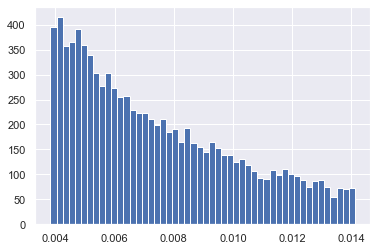

In [126]:
rets_df[classes[0]==3].hist(bins=50);

In [ ]:
custommmmmm

In [45]:
classes.value_counts().sum()

43888

In [47]:
250/43888

0.005696317900109369

In [104]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=10)
selected_features_train = selector.fit_transform(train_data, y_train)
selected_features_test = selector.transform(test_data)

In [ ]:
imbalanced deep learning

In [ ]:
#fonction a maximiser => rentabilité cumulée(voir projet paris sportifs)
#nombre de clusters a reglers selon les perfs du machine learning
donner classements au cluster
ncluster a optimiser aussi

In [39]:
minmiser la fonction de mauvaises décisions +> positives tres negatives
predict proba + portefeuille simulation
plot decisiontree lgbm

outliers et faeture selection

convertir classe dans le meme univers en fonction du ranking (---,--,-,0,+,++,+++)

SyntaxError: invalid syntax (2866234363.py, line 1)

In [93]:
predictions.value_counts()

0     6095
12     281
18     205
11     200
17     142
19     113
1       43
5       35
20      28
15      27
dtype: int64

In [23]:
close_features = extract_features(test[["index", "Close"]], column_id='index')

Feature Extraction: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


In [49]:
indexed_data = data.copy()
indexed_data['id'] = pd.Series(range(len(indexed_data)), index=data.index)

In [50]:
indexed_data = indexed_data.reset_index().iloc[:,1:].reset_index()

In [75]:
close_relevant_features = select_features(nanless_close_features.reset_index().iloc[1:,1:], indexed_data['Close'].diff().iloc[1:])

In [67]:
nanless_close_features = close_features.T.dropna().T.copy()

#au lieu de faire le dropna() faire du back fill et drop ceux avec trop de d onnées manquantes

In [ ]:
https://www.kaggle.com/code/patrickurbanke/feature-engineering-for-time-series

In [ ]:
polynomial elbow + kmeans test train
#differencier 1, 2, 3 fois
#n x n features